# Tasks to Accomplish:
* Conduct any data cleaning to make it better
* Remove jargon/unnecessary words
* Can you define each tweet as positive/negative?
* Post this conduct analysis to provide any unique results, for example conduct cluster analysis
* Create any visual charts around your findings

In [34]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#pd.set_option("display.max_colwidth", 300)
stp_words = stopwords.words('english')
stp_words.extend(['rt', 'vs', 'amp', 'quot', 'gt'])
print(stp_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [3]:
#Read Given Tweets
tweet_data = pd.read_excel("../input/TWEET STACK.XLSX", dtype={'TweetFulltext' : str})
tweet_data.head(10)

,TweetFulltext
0,A.I. #Songwriting Has Arrived. \n\nDon't Panic...
1,"IBM explores the intersection \n\nof #AI, #eth..."
2,RT @SpirosMargaris: Good read\n\n#MachineLearn...
3,RT @SpirosMargaris: ICOs vs. #STOs: \n\nHow to...
4,RT @SpirosMargaris: ‘Ditch the #PingPongTable’...
5,RT @SpirosMargaris: This #portrait made by #AI...
6,RT @SpirosMargaris: Detecting #Crime \n\nThrou...
7,RT @Salz_Er: Vontobel bringt einen Robo Adviso...
8,RT @andi_staub: [ #techforgood ]\n\n#Blockchai...
9,RT @dinisguarda: In our new digital data driv...


# Cleaning Data
* Remove the user handles (Ex. @xyz). They are no use to us.
* Remove web URLs.
* Remove special characters.
* Remove stopwords
* Perform stemming

In [4]:
def clean_tweets(tweet_txt):
    #Removing Handles
    tweet_txt_new = re.sub("@[\w]*", " ", tweet_txt)
    #Removing URLs
    tweet_txt_new = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", tweet_txt_new)
    #Removing punctation marks
    tweet_txt_new = re.sub("[^a-zA-Z#]", " ", tweet_txt_new)
    #Removing hashes
    tweet_txt_new = tweet_txt_new.replace('#', '')
    #Removing stop words
    words = [word.lower() for word in tweet_txt_new.split()]
    
    for stp_word in stp_words:
        if stp_word in words:
            words = list(filter(lambda a: a != stp_word, words))
    #Stemming words        
    stemmer = PorterStemmer()
    words_stemmed = [stemmer.stem(i) for i in words]
    return " ".join(words_stemmed)

In [5]:
# Take user handles
def extract_user_handles(tweet):
    user_handles = re.findall("@[\w]*", tweet)
    return "|".join(user_handles).replace("@", "")

def extract_hash_tags(tweet):
    tags = re.findall("#[\w]*", tweet)
    return "|".join(tags).replace("#", "")

In [6]:
tweet_data['TweetFulltext_cleaned'] = tweet_data.apply(lambda x: clean_tweets(x['TweetFulltext']), axis=1)
tweet_data['handles'] = tweet_data.apply(lambda x: extract_user_handles(x['TweetFulltext']), axis=1)
tweet_data['tags'] = tweet_data.apply(lambda x: extract_hash_tags(x['TweetFulltext']), axis=1)
tweet_data.head(10)

,TweetFulltext,TweetFulltext_cleaned,handles,tags
0,A.I. #Songwriting Has Arrived. \n\nDon't Panic...,songwrit arriv panic fintech music ai artifici...,danreilly11,Songwriting|fintech|music|AI|ArtificialIntelli...
1,"IBM explores the intersection \n\nof #AI, #eth...",ibm explor intersect ai ethic pacman fintech i...,harrymccracken|jblefevre60|JohnSnowai|pierrepi...,AI|ethics|PacMan|fintech|insurtech|ArtificialI...
2,RT @SpirosMargaris: Good read\n\n#MachineLearn...,good read machinelearn new languag leadership ...,SpirosMargaris,MachineLearning|Leadership|fintech|insurtech|A...
3,RT @SpirosMargaris: ICOs vs. #STOs: \n\nHow to...,ico sto know one right busi fintech startup vc...,SpirosMargaris,STOs|fintech|startup|VC|ICO
4,RT @SpirosMargaris: ‘Ditch the #PingPongTable’...,ditch pingpongt tip make workplac better finte...,SpirosMargaris,PingPongTable|Workplace|fintech|insurt
5,RT @SpirosMargaris: This #portrait made by #AI...,portrait made ai sold time origin estim,SpirosMargaris,portrait|AI|
6,RT @SpirosMargaris: Detecting #Crime \n\nThrou...,detect crime artificialintellig fintech insurt...,SpirosMargaris,Crime|ArtificialIntelligence|fintech|insurtech...
7,RT @Salz_Er: Vontobel bringt einen Robo Adviso...,vontobel bringt einen robo advisor mehr zum th...,Salz_Er|FuW_News|cashc,robo
8,RT @andi_staub: [ #techforgood ]\n\n#Blockchai...,techforgood blockchain social impact fintech i...,andi_staub|Stevewal63,techforgood|Blockchain|fintech|insurtech|bitco...
9,RT @dinisguarda: In our new digital data driv...,new digit data driven world blockchain ai foun...,dinisguarda,Blockchain|AI|tech


In [7]:
tweet_data = tweet_data.drop('TweetFulltext', axis=1)
tweet_data.head(10)

,TweetFulltext_cleaned,handles,tags
0,songwrit arriv panic fintech music ai artifici...,danreilly11,Songwriting|fintech|music|AI|ArtificialIntelli...
1,ibm explor intersect ai ethic pacman fintech i...,harrymccracken|jblefevre60|JohnSnowai|pierrepi...,AI|ethics|PacMan|fintech|insurtech|ArtificialI...
2,good read machinelearn new languag leadership ...,SpirosMargaris,MachineLearning|Leadership|fintech|insurtech|A...
3,ico sto know one right busi fintech startup vc...,SpirosMargaris,STOs|fintech|startup|VC|ICO
4,ditch pingpongt tip make workplac better finte...,SpirosMargaris,PingPongTable|Workplace|fintech|insurt
5,portrait made ai sold time origin estim,SpirosMargaris,portrait|AI|
6,detect crime artificialintellig fintech insurt...,SpirosMargaris,Crime|ArtificialIntelligence|fintech|insurtech...
7,vontobel bringt einen robo advisor mehr zum th...,Salz_Er|FuW_News|cashc,robo
8,techforgood blockchain social impact fintech i...,andi_staub|Stevewal63,techforgood|Blockchain|fintech|insurtech|bitco...
9,new digit data driven world blockchain ai foun...,dinisguarda,Blockchain|AI|tech


In [8]:
#Generating Top Handle Mentions
handle_dict = {}
tag_dict = {}

for i in range(tweet_data.shape[0]):
    user_handles = tweet_data.handles[i].split('|')
    tweet_tags = tweet_data.tags[i].split('|')
    
    # Counting occurence of user handles
    for user_handle in user_handles:
        if user_handle not in handle_dict:
            handle_dict[user_handle] = 0
        handle_dict[user_handle] += 1
    
    # Counting occurence of tags
    for tweet_tag in tweet_tags:
        if tweet_tag.lower() not in tag_dict:
            tag_dict[tweet_tag.lower()] = 0
        tag_dict[tweet_tag.lower()] += 1

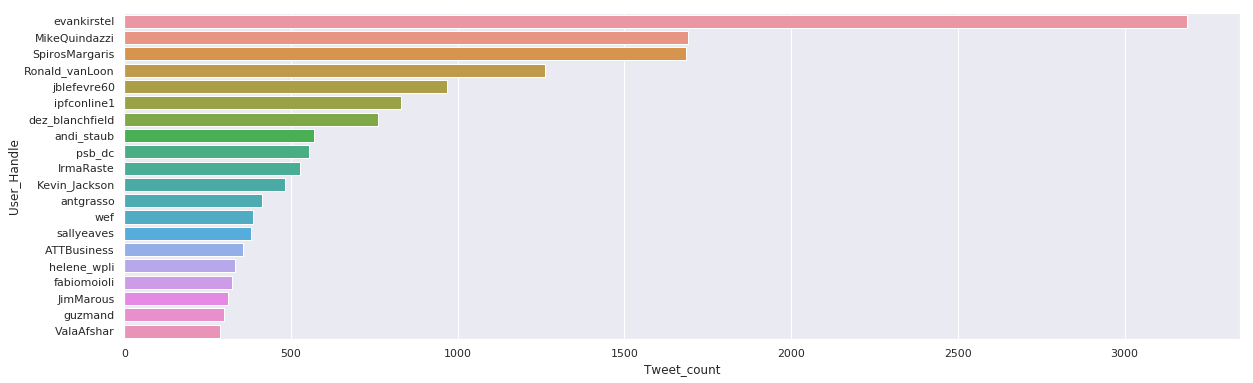

In [9]:
if "" in handle_dict:
    del handle_dict[""]
handle_dict_sorted = sorted(handle_dict.items(), key=lambda item: item[1], reverse=True)
# handle, freq = zip(*handle_dict_sorted[:20])
df = pd.DataFrame(handle_dict_sorted[:20], columns=['User_Handle', 'Tweet_count'])
sns.set(style="darkgrid")
plt.figure(figsize=(20,6))
p = sns.barplot(y='User_Handle', x = "Tweet_count", data=df)

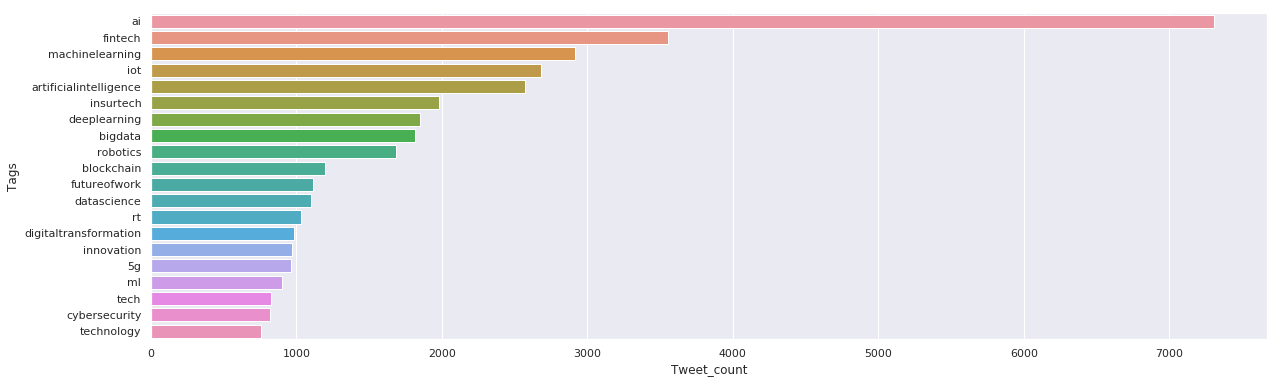

In [10]:
if "" in tag_dict:
    del tag_dict[""]
tag_dict_sorted = sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)
df = pd.DataFrame(tag_dict_sorted[:20], columns=['Tags', 'Tweet_count'])
sns.set(style="darkgrid")
plt.figure(figsize=(20,6))
p = sns.barplot(y='Tags', x = "Tweet_count", data=df)

In above plots I have taken top 20 occurences. We can see that all the hash tags are related to Data Science field.
Hash tag "ai" is occured in ~7400 tweets out of 60K tweets.

# Training Data

I searched this dataset through Google's dataset search [Google's dataset search](https://toolbox.google.com/datasetsearch/search?query=Twitter%20Sentiment&docid=6srYA%2Bi3qZssY3ztAAAAAA%3D%3D)

Here I am using this tagged data to train the model.

In [11]:
# Reading already tagged dataset
cols = ['sentiment','ids','date','flag','user','text']
training_data = pd.read_csv("../input/training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding="ISO-8859-1")
training_data.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [12]:
training_data = training_data.drop(['ids', 'date', 'flag', 'user'], axis=1)
training_data.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [13]:
training_data.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [14]:
# Changing the sentiment tagging as 0 -> 0 and 4 -> 1 in setiment column
training_data.sentiment = training_data.sentiment.map({0:0, 4:1})
training_data.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [15]:
# Cleaning the tweets of the tagged dataset
training_data['tweet_txt_cleaned'] = training_data.apply(lambda x: clean_tweets(x['text']), axis=1)
training_data.head()

,sentiment,text,tweet_txt_cleaned
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behav mad see


In [16]:
# Here we saw that few cleaned tweets have no text after cleaning. We have to remove those data from the dataset.
training_data[training_data.tweet_txt_cleaned == ""].sentiment.value_counts()

1    4307
0    3971
Name: sentiment, dtype: int64

In [17]:
training_data = training_data[training_data.tweet_txt_cleaned != ""]
training_data.sentiment.value_counts()

0    796029
1    795693
Name: sentiment, dtype: int64

In [18]:
training_data = training_data.drop(['text'], axis=1)

# Train word2vec model

In [19]:
# Tokenize training data for creating word2vec vectors
training_data_tokenized = training_data.tweet_txt_cleaned.apply(lambda x: x.split())
word2vec_model = gensim.models.Word2Vec(training_data_tokenized, size=300, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 17)

In [20]:
def gen_tweet_vec(tokens, vocab_len):
    "Generates the vector for entire tweet as weighted average of the individual vectors of the words in the tweet"
    vec = np.zeros(vocab_len).reshape((1, vocab_len))
    token_cnt = 0
    for word in tokens:
        try:
            vec += word2vec_model[word].reshape((1, vocab_len))
            token_cnt += 1
        except KeyError:
            continue
    if token_cnt != 0:
        vec /= float(token_cnt)
    return vec

In [21]:
# Splitting the dataset in to test and train dataset.
train_data, test_data = train_test_split(training_data, test_size=0.2, random_state=51)
y_train_data = pd.DataFrame({'sentiment': train_data.values[:, 0]})
y_train_data = y_train_data.astype('int')
y_test_data = pd.DataFrame({'sentiment': test_data.values[:, 0]})
y_test_data = y_test_data.astype('int')
x_train_data = pd.DataFrame({'text': train_data.values[:, 1]})
x_test_data = pd.DataFrame({'text': test_data.values[:, 1]})

In [22]:
# Tokeninzing the cleaned tweets in test and train split.
x_train_data = x_train_data.text.apply(lambda x: x.split())
x_test_data = x_test_data.text.apply(lambda x: x.split())

In [23]:
# Generating word2vec vectors for train and test split.
# For calculating the sentence vector of each tweet, I have calculated the average of the the word2vec vectors of all the words that are present in our
# word2vecc model's dictionary

x_train_data_vectors = np.zeros((len(x_train_data), 300)) 
for i in range(len(x_train_data)):
    x_train_data_vectors[i,:] = gen_tweet_vec(x_train_data[i], 300)
x_train_data_vectors = pd.DataFrame(x_train_data_vectors)

x_test_data_vectors = np.zeros((len(x_test_data), 300)) 
for i in range(len(x_test_data)):
    x_test_data_vectors[i,:] = gen_tweet_vec(x_test_data[i], 300)
x_test_data_vectors = pd.DataFrame(x_test_data_vectors)

In [24]:
print(x_test_data_vectors.shape, y_test_data.shape, x_test_data.shape)

(318345, 300) (318345, 1) (318345,)


In [25]:
# Generating word2vec vector for given data (unlabelled dataset)
x_tweet_data_vectors = np.zeros((len(tweet_data.TweetFulltext_cleaned), 300)) 
for i in range(len(tweet_data.TweetFulltext_cleaned)):
    x_tweet_data_vectors[i,:] = gen_tweet_vec(tweet_data.TweetFulltext_cleaned[i], 300)
x_tweet_data_vectors = pd.DataFrame(x_tweet_data_vectors)

In [26]:
# Creating logistic regression model and gerating f1 score
lreg = LogisticRegression().fit(x_train_data_vectors, y_train_data)
prediction = lreg.predict(x_test_data_vectors)
f1_score(y_test_data, prediction)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7429166783643243

In [27]:
#prediction of given data
prediction_given_data = lreg.predict(x_tweet_data_vectors)

In [28]:
tweet_data['sentiment'] = prediction_given_data
tweet_data['sentiment'].value_counts()

1    59751
0      248
Name: sentiment, dtype: int64

In [29]:
tweet_data[tweet_data.sentiment == 1].head(10)

,TweetFulltext_cleaned,handles,tags,sentiment
0,songwrit arriv panic fintech music ai artifici...,danreilly11,Songwriting|fintech|music|AI|ArtificialIntelli...,1
1,ibm explor intersect ai ethic pacman fintech i...,harrymccracken|jblefevre60|JohnSnowai|pierrepi...,AI|ethics|PacMan|fintech|insurtech|ArtificialI...,1
2,good read machinelearn new languag leadership ...,SpirosMargaris,MachineLearning|Leadership|fintech|insurtech|A...,1
3,ico sto know one right busi fintech startup vc...,SpirosMargaris,STOs|fintech|startup|VC|ICO,1
4,ditch pingpongt tip make workplac better finte...,SpirosMargaris,PingPongTable|Workplace|fintech|insurt,1
5,portrait made ai sold time origin estim,SpirosMargaris,portrait|AI|,1
6,detect crime artificialintellig fintech insurt...,SpirosMargaris,Crime|ArtificialIntelligence|fintech|insurtech...,1
7,vontobel bringt einen robo advisor mehr zum th...,Salz_Er|FuW_News|cashc,robo,1
8,techforgood blockchain social impact fintech i...,andi_staub|Stevewal63,techforgood|Blockchain|fintech|insurtech|bitco...,1
9,new digit data driven world blockchain ai foun...,dinisguarda,Blockchain|AI|tech,1


In [33]:
tweet_data[tweet_data.sentiment == 0].head(10)

,TweetFulltext_cleaned,handles,tags,sentiment
29,airbnb bc,evankirstel,Airbnb,0
277,tbh,deadsquid|potch|Twitch|glitch,,0
1111,hard f,peterwells|jack,,0
1144,share care,evankirstel,,0
1187,market vr arcad requir creativ messag arvr,,ARVR,0
1297,ahhhhhhh,johnstarky|ReaMrlBoyo|ATTBusiness,,0
1337,dvd,StephMBuck,,0
1933,haha,SusanaDeLeonMD,,0
2409,thread,dens|esnytrash|jcro|shooops,,0
2434,car invis porsch,,,0


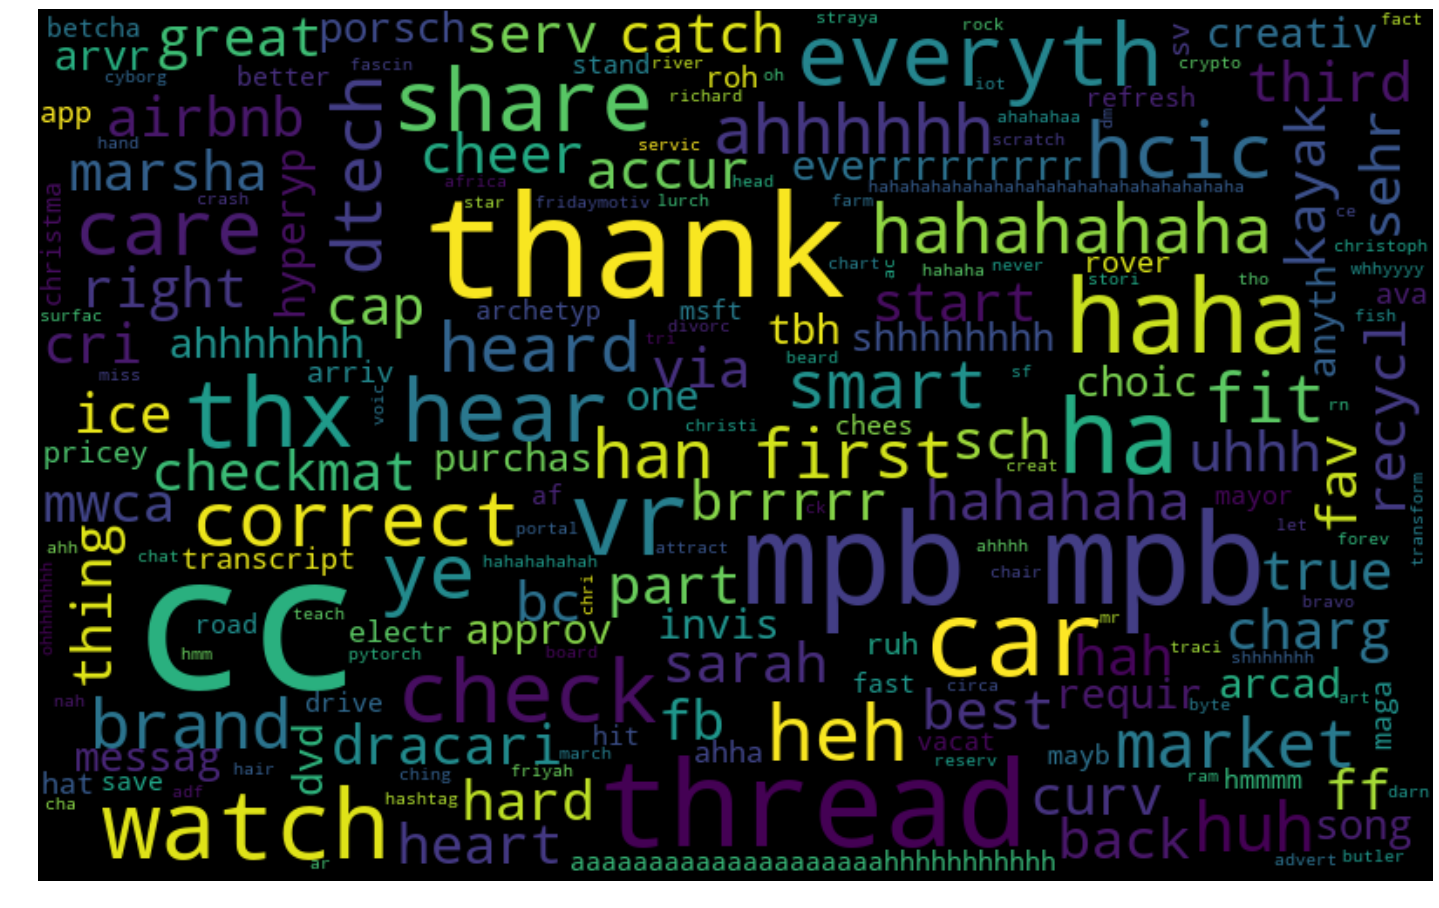

In [35]:
# Generating word-cloud to see the most prominent words in the negative sentiment tweets
# The size of the word is directly proportional to its occurence.
negative_setiment_df = tweet_data[tweet_data.sentiment == 0]
combined_corpus_text = ' '.join([text for text in negative_setiment_df['TweetFulltext_cleaned']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_corpus_text) 
plt.figure(figsize=(25, 25))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* In the above word cloud for negative sentiments tagged data, we see that there are very less negative words.
* But at the same time we see that the mojority of the words doesn't belong to Data Science field.

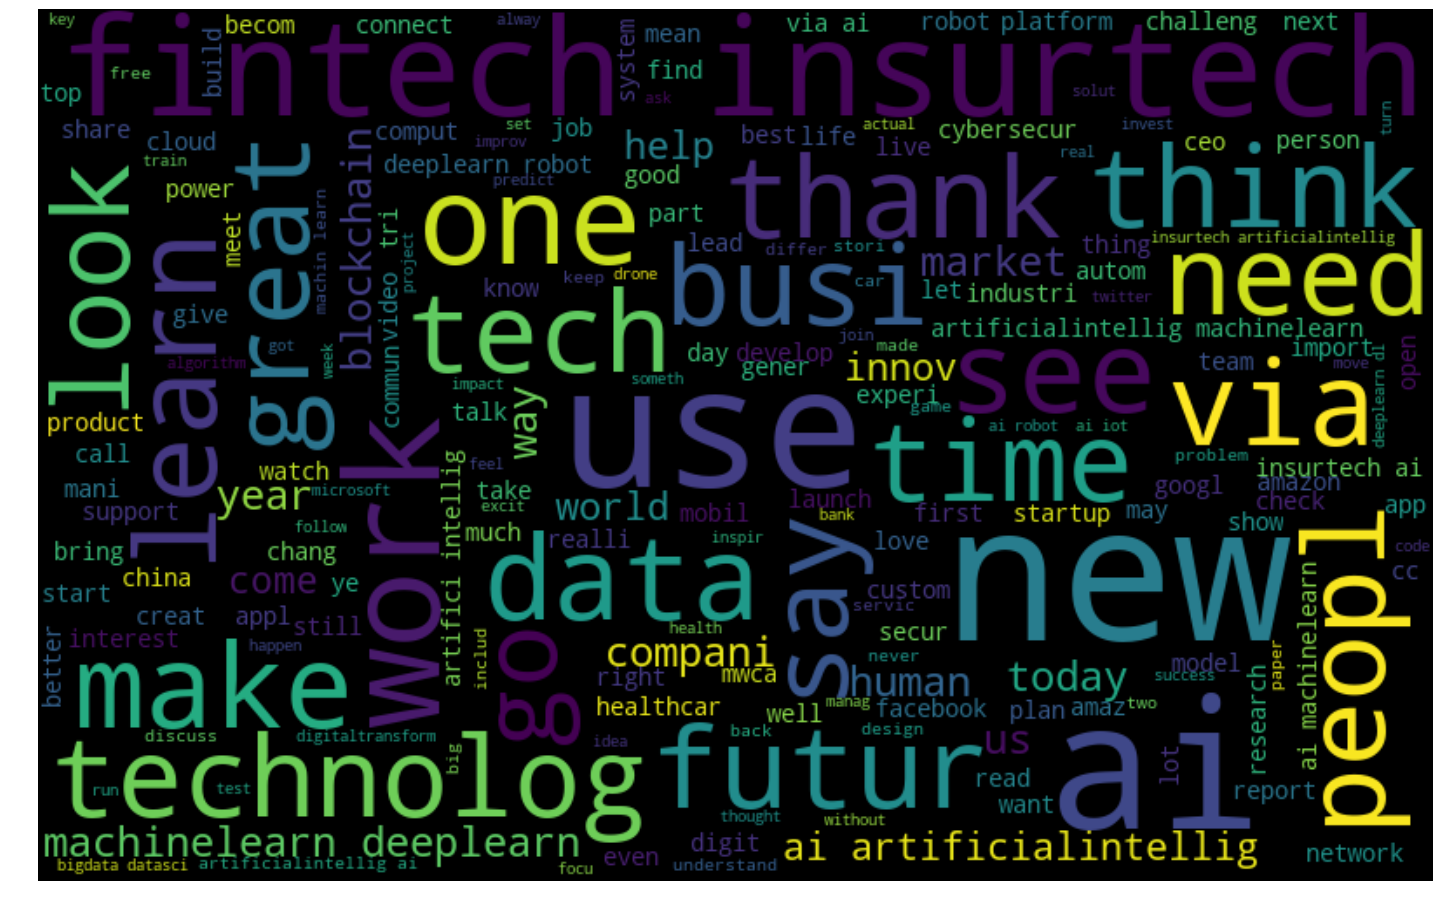

In [36]:
# Generating word-cloud to see the most prominent words in the positive sentiment tweets
# The size of the word is directly proportional to its occurence.
positive_setiment_df = tweet_data[tweet_data.sentiment == 1]
combined_corpus_text = ' '.join([text for text in positive_setiment_df['TweetFulltext_cleaned']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_corpus_text) 
plt.figure(figsize=(25, 25))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()